In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import os
from helper import *
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.decomposition import PCA
import datetime

In [2]:
data_folder = 'dataset/'
categories_list = ['isFraud']+['id_'+str(x) for x in range(12,39)]+['DeviceInfo','DeviceType','R_emaildomain','P_emaildomain','addr1','addr2','ProductCD'] + ['M'+str(x) for x in range(1,10)] + ['card'+str(x) for x in range(1,7)]+['Hours']

The below code snippet imports the dataset saved in pickle format if it exists, otherwise it imports from the csv files, reduces the memory allocation and saves it into pickle for next use

In [3]:
test_f = data_folder+'test.pkl'
train_f = data_folder+'train.pkl'

if os.path.isfile(train_f):
    train = pd.read_pickle(data_folder+'train.pkl')
else:    
    train_transaction = pd.read_csv(data_folder+'train_transaction.csv')
    train_identity = pd.read_csv(data_folder+'train_identity.csv')
    train = reduce_memory_usage(train_transaction.merge(train_identity, how='left', left_index=True, right_index=True, on='TransactionID'), categories=categories_list)
    train.to_pickle(data_folder+'train.pkl')
    del train_identity, train_transaction
    
if os.path.isfile(test_f):
    test = pd.read_pickle(data_folder+'test.pkl')
else:
    test_transaction = pd.read_csv(data_folder+'test_transaction.csv')
    test_identity = pd.read_csv(data_folder+'test_identity.csv')
    test = reduce_memory_usage(test_transaction.merge(test_identity, how='left', left_index=True, right_index=True, on='TransactionID'),categories=categories_list)
    test.to_pickle(data_folder+'test.pkl')
    del test_identity, test_transaction

In [4]:
# So as to avoid making mistakes in the main copy
Ttrain = train.copy()
Ttest = test.copy()

In [5]:
train_target = pd.DataFrame()
test_target = pd.DataFrame()

In [6]:
# converting  the date into hours (since the dates of training and test set dont match, and also some other submissions show a relation between 
# hour of transaction and % fraud)
START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
Ttrain['Date'] = Ttrain['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
Ttest['Date'] = Ttest['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
Ttrain['Hours'] = assign_category(Ttrain['Date'].dt.hour)
Ttest['Hours'] = assign_category(Ttest['Date'].dt.hour)

In [7]:
test_tran_id = Ttest['TransactionID'][0]

In [8]:
full_ds = pd.concat([Ttrain.drop(['isFraud'],axis=1),Ttest], axis=0, join='outer', ignore_index=False, keys=None, levels=None, names=None, verify_integrity=False, copy=True).reset_index(drop=True)

In [9]:
full_ds['logTAmt'] = np.log(full_ds['TransactionAmt'])
full_ds['NrmTAmt'] = full_ds['logTAmt']-full_ds['logTAmt'].mean()

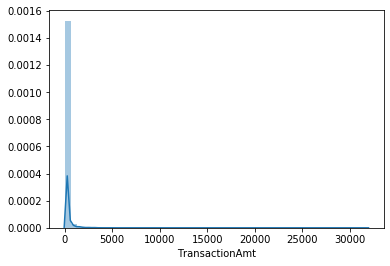

In [54]:
sns.distplot(full_ds['TransactionAmt'])
# transaction amount is badly distributed

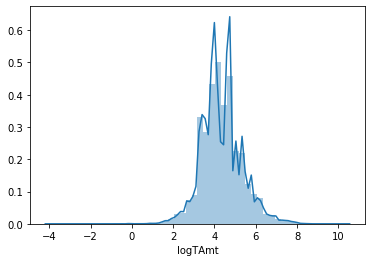

In [52]:
sns.distplot(full_ds['logTAmt'])
# the logarithm is well distributed

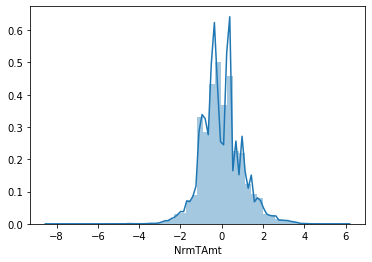

In [53]:
sns.distplot(full_ds['NrmTAmt'])
# mean is now shifted

In [10]:
categories = categories_list[1:] # all categories except 'isFraud'
category_means={}

for elem in categories:
    category_means[elem] = calc_group_mean(df=full_ds,group_of=elem,mean_of='NrmTAmt') # calculate groupwise mean of NrmTAmt

In [11]:
for elem in categories: # subtract groupwise mean from NrmTAmt 
    full_ds[elem] = full_ds['NrmTAmt']-map_to_groups(df=full_ds,group_of=elem,map_dict=category_means[elem],convert_type=np.float32)

In [12]:
summarize(full_ds[['card5']])

Dataset Shape: (1097231, 1)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,card5,float32,0,65270,-0.317914,-1.355076,-0.11831,10.56


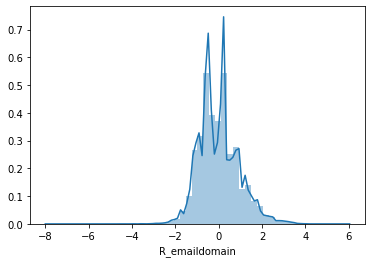

In [13]:
sns.distplot(full_ds['R_emaildomain'])

In [14]:
non_categories_C = ['C'+str(i) for i in range(1,15)]
non_categories_D = ['D'+str(i) for i in range(1,16)]
non_categories_V = ['V'+str(i) for i in range(1,340)]
non_categories_id = ['id_0'+str(i) for i in range(1,10)]+['id_10','id_11']
continuous = non_categories_C+non_categories_D+non_categories_V+non_categories_id

Dataset Shape: (1097231, 379)


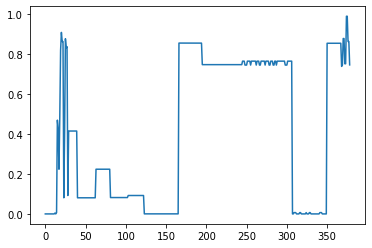

In [15]:
continuous_summary = summarize(full_ds[continuous])
plt.plot(continuous_summary['Missing']/full_ds.shape[0])
# below is a plot of % missing values, I chose to ignore the columns with more than 70% missing values

In [16]:
considered_cont, nonconsidered_cont = ignore_categories_nan(threshold=0.7,df=Ttrain,categories=continuous)

In [17]:
considered_cont_df, min_max_dct = min_max_scale(df=full_ds,categories=considered_cont) # the continuous values are scaled

In [18]:
considered_cont_df.isnull().sum().sum() # so many missing numbers in the dataset

17996183

In [19]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(considered_cont_df) # simple imputer is used to fill in the missing values

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='mean', verbose=0)

In [20]:
imputed_cont_df = pd.DataFrame(imputer.transform(considered_cont_df),columns=considered_cont)

In [21]:
n_components = 100 # PCA is used to convert continuous columns into 100 dimensions
new_sols = ['cont'+str(i) for i in range(n_components)]
pca_cont = PCA(n_components=n_components)
pca_cont.fit(imputed_cont_df)
new_cont = pd.DataFrame(pca_cont.transform(imputed_cont_df),columns = new_sols)

In [22]:
train_size = Ttrain.shape
train_target, test_target = new_cont[0:train_size[0]],new_cont[train_size[0]:]

In [23]:
train_target = train_target.merge(full_ds.loc[0:train_size[0],categories],how='left', left_index=True, right_index=True)
test_target = test_target.merge(full_ds.loc[train_size[0]:,categories],how='left', left_index=True, right_index=True)
train_target['NrmTAmt'] = full_ds.loc[0:train_size[0],'NrmTAmt']
test_target['NrmTAmt'] = full_ds.loc[train_size[0]:,'NrmTAmt']

In [24]:
training_labels = Ttrain['isFraud']

A linear Regressor with 10 folds is used. But as seen with 400 iterations, the regressor doesn't converge

In [25]:
model = LogisticRegression(random_state = 42, solver='lbfgs', multi_class='multinomial', max_iter=400)
model, scores_valid, y_preds = Kfold_classifier(X=train_target, y = training_labels, X_test=test_target, n_folds = 10, model = model)

e:\rohit\documents\mlfm\own\ieee-cis-fraud-detection\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
e:\rohit\documents\mlfm\own\ieee-cis-fraud-detection\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
e:\rohit\documents\mlfm\own\ieee-cis-fraud-detection\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
e:\rohit\documents\mlfm\own\ieee-cis-fraud-detection\venv\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
e:\rohit\documents\mlfm\own\ieee-cis-fraud-detection\venv\li

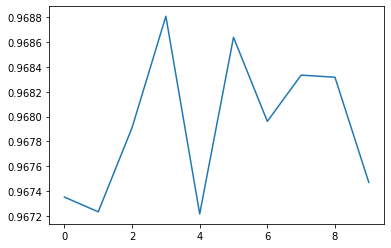

In [27]:
plt.plot(scores_valid)

In [43]:
sol_reg = pd.DataFrame()
sol_reg['TransactionID'] = Ttest['TransactionID']
sol_reg['isFraud'] = y_preds[-1][0]
sol_reg.to_csv(data_folder+'reg_last.csv',index=False)

![dataset/reg-last.png](dataset/reg-last.PNG)
The Linear regressor gives a score of 0.5811
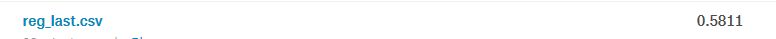

In [49]:
from sklearn.model_selection import KFold, TimeSeriesSplit
n_fold = 5
folds = TimeSeriesSplit(n_splits=n_fold)
folds = KFold(n_splits=5)
params = {'num_leaves': 256,
          'min_child_samples': 79,
          'objective': 'binary',
          'max_depth': 13,
          'learning_rate': 0.03,
          "boosting_type": "gbdt",
          "subsample_freq": 3,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3,
          'reg_lambda': 0.3,
          'colsample_bytree': 0.9,
         }
# lightgbm classifier is used with the above parameters on the training set with 5 folds

Fold 1 started at Sun Sep 15 22:45:53 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.989643	training's custom MSE: 0.00904212	valid_1's auc: 0.870863	valid_1's custom MSE: 0.0188651
Early stopping, best iteration is:
[366]	training's auc: 0.984103	training's custom MSE: 0.010993	valid_1's auc: 0.872371	valid_1's custom MSE: 0.0189512
Fold 2 started at Sun Sep 15 22:49:07 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.990731	training's custom MSE: 0.00788041	valid_1's auc: 0.89433	valid_1's custom MSE: 0.0251803
Early stopping, best iteration is:
[454]	training's auc: 0.989277	training's custom MSE: 0.00839977	valid_1's auc: 0.894629	valid_1's custom MSE: 0.0251803
Fold 3 started at Sun Sep 15 22:53:23 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[297]	training's auc: 0.98101	training's custom MSE: 0.0111586	valid_1's auc: 0.898344	valid_1's

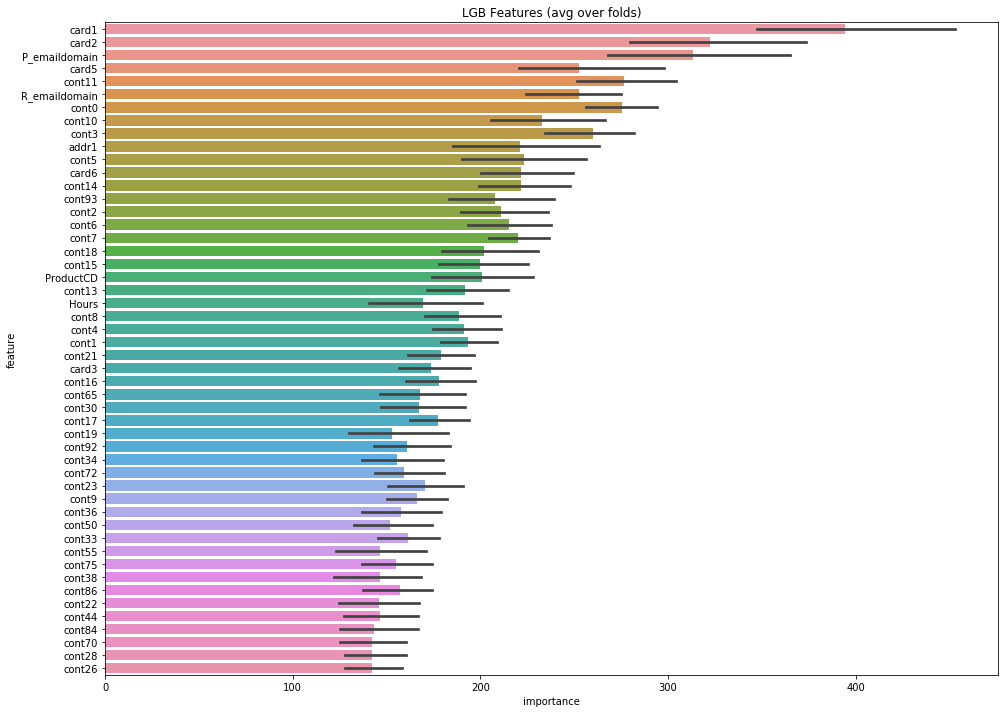

In [50]:
result_dict_lgb = train_model_classification(X=train_target, X_test=test_target, y=training_labels, params=params, folds=folds, model_type='lgb', eval_metric='auc', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000, averaging='usual', n_jobs=-1)

In [51]:
sol_lgb = pd.DataFrame()
sol_lgb['TransactionID'] = Ttest['TransactionID']
sol_lgb['isFraud'] = result_dict_lgb['prediction']
sol_lgb.to_csv(data_folder+'lgb.csv',index=False)

![dataset/lgb.png](dataset/lgb.PNG)
This method gives a prediction score of 0.9095